# Convolutional Neural Networks

## Project: Algorithm for a Dog Identification App 

An algorithm that could be used as part of a mobile or web app.  At the end of this project, the code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

There is a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.


## Import packages and datasets

### Import packages

In the code cell below, I import all the required packages for this project.

In [ ]:
import numpy as np
import glob
import random
import cv2                
import matplotlib.pyplot as plt 

from sklearn.datasets import load_files   

from tqdm import tqdm
from PIL import ImageFile 

from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image                                      
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [ ]:
random.seed(8675309)

In [ ]:
%matplotlib inline  

### Import dog dataset

In the code cell below, I import a dataset of dog images.  I populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
# function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Detect human faces

OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is used to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  I have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, a demonstration in how to use this detector to find human faces in a sample image.

Number of faces detected: 1


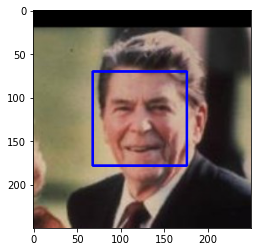

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box. The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assessing the human face detector

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that the algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
accuracy_face_human = 0
accuracy_face_dog = 0

for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]):
        accuracy_face_human += 1
        
for i in range(len(dog_files_short)):        
    if face_detector(dog_files_short[i]):
        accuracy_face_dog += 1
        
print('Accuracy of face detection in humans: ' + str(100*accuracy_face_human/len(human_files_short)) + '%')
print('Accuracy of face detection in dogs: ' + str(100*accuracy_face_dog/len(dog_files_short)) + '%')

Accuracy of face detection in humans: 100.0%
Accuracy of face detection in dogs: 12.0%


---
<a id='step2'></a>
## Detect dogs

In this section, I use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  The first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [8]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [9]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making redictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  You can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that there is a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [10]:
def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assessment of the dog detector

In the cell below, I test the accuracy of the dog detector by using ResNet50 prediction

In [12]:
accuracy_dog_human = 0
accuracy_dog_dog = 0

for i in range(len(human_files_short)):
    if dog_detector(human_files_short[i]):
        accuracy_dog_human += 1
        
for i in range(len(dog_files_short)):        
    if dog_detector(dog_files_short[i]):
        accuracy_dog_dog += 1
        
print('Accuracy of dog detection in humans: ' + str(100*accuracy_dog_human/len(human_files_short)) + '%')
print('Accuracy of dog detection in dogs: ' + str(100*accuracy_dog_dog/len(dog_files_short)) + '%')

Accuracy of dog detection in humans: 1.0%
Accuracy of dog detection in dogs: 100.0%


---
<a id='step3'></a>
## A CNN to classify dog breeds (from scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, I created a CNN that classifies dog breeds from scratch that reaches a test accuracy of at least 2%. It is important to mention that in practice it is better to start from a pre-trained model and use transfer-learning to accomplish this type of tasks. However, as a demonstration, here it is a CNN train to classify dog breeds from scratch.

The task of assigning breed to dogs from images is considered exceptionally challenging. To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  The vision-based algorithms will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imbalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 836/836 [00:26<00:00, 31.85it/s]


### Model architecture

In [14]:
model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(16, 2, strides = 1, padding = 'SAME', activation = 'relu', input_shape= (224, 224, 3)))
model.add(MaxPooling2D(2, strides = 2, padding = 'SAME'))
model.add(Conv2D(32, 2, strides = 1, padding = 'SAME', activation = 'relu'))
model.add(MaxPooling2D(2, strides = 2, padding = 'SAME'))
model.add(Dropout(0.25))
model.add(Conv2D(64, 2, strides = 1, padding = 'SAME', activation = 'relu'))
model.add(MaxPooling2D(2, strides = 2, padding = 'SAME'))
model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dense(133, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)       

### Compile the model

In [15]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the model

Using chackpointers to save the progress

In [16]:
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 199s 30ms/step - loss: 4.8790 - accuracy: 0.0112 - val_loss: 4.8598 - val_accuracy: 0.0120

Epoch 00001: val_loss improved from inf to 4.85983, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/10
6680/6680 [==============================] - 203s 30ms/step - loss: 4.8326 - accuracy: 0.0153 - val_loss: 4.8243 - val_accuracy: 0.0192

Epoch 00002: val_loss improved from 4.85983 to 4.82431, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/10
6680/6680 [==============================] - 208s 31ms/step - loss: 4.7996 - accuracy: 0.0178 - val_loss: 4.8129 - val_accuracy: 0.0180

Epoch 00003: val_loss improved from 4.82431 to 4.81291, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/10
6680/6680 [==============================] - 206s 31ms/step - loss: 4.7813 - accuracy: 0.0198 - val_loss: 4.7942 - val_accuracy: 0.0192

Epoch 00004: val_

### Load the model with the best validation loss

In [17]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the chosen model

In [18]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 3.3493%


---
<a id='step5'></a>
## A CNN to classify dog breeds (using transfer learning)

I used transfer learning to create a CNN using VGG-19 bottleneck features.  There are others available pre-computed the bottleneck features for this task for all of the networks currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  You're free to pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain bottleneck features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets.

In [27]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### Model architecture

A model that has as input the dog bottleneck features of VGG-19 trained network and trains the model on top of that. 

In [28]:
VGG19_JR_model = Sequential()
VGG19_JR_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_JR_model.add(Dense(256, activation='relu'))
VGG19_JR_model.add(Dropout(0.5))
VGG19_JR_model.add(Dense(133, activation='softmax'))
VGG19_JR_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               34181     
Total params: 165,509
Trainable params: 165,509
Non-trainable params: 0
_________________________________________________________________


### Compile the model

In [29]:
VGG19_JR_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model

Using model checkpointing to save the model that attains the best validation loss.  

In [31]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_JR_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
6680/6680 [==============================] - 2s 302us/step - loss: 1.1060 - accuracy: 0.7202 - val_loss: 1.1084 - val_accuracy: 0.7126

Epoch 00001: val_loss improved from inf to 1.10841, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 2/50
6680/6680 [==============================] - 2s 332us/step - loss: 1.1047 - accuracy: 0.7168 - val_loss: 1.0933 - val_accuracy: 0.7509

Epoch 00002: val_loss improved from 1.10841 to 1.09335, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 3/50
6680/6680 [==============================] - 2s 349us/step - loss: 1.0173 - accuracy: 0.7421 - val_loss: 1.1402 - val_accuracy: 0.7305

Epoch 00003: val_loss did not improve from 1.09335
Epoch 4/50
6680/6680 [==============================] - 2s 329us/step - loss: 1.0256 - accuracy: 0.7481 - val_loss: 1.2183 - val_accuracy: 0.7377

Epoch 00004: val_loss did not improve from 1.09335
Epoch 5/50
6680/6680 [===========================

### Load the model with the best validation loss

In [32]:
VGG19_JR_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### Test the model

We can see here a huge difference between the test accuracy of a model trained from scratch (>3%) and the test accuracy of a model trained on top of another model (VGG-19) using tranfer learning. A test accuracy above 74%.

In [33]:
# get index of predicted dog breed for each image in test set
VGG19_JR_predictions = [np.argmax(VGG19_JR_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_JR_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_JR_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 74.2823%


### Predict dog breed with the model of any image

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell. You can obtain the bottleneck features of different CNN architectures, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def VGG19_JR_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG19(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG19_JR_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step7'></a>
## Test the algorithm on Sample Images

* Is it a human? - Use face detector
* Is it a dog? - Use dog detector
* What dog breed is it? - Use VGG-19 + model for prediction


Is it a human face? False
Does it look like a dog? True
 
If you're truly a dog then you might be a chow chow


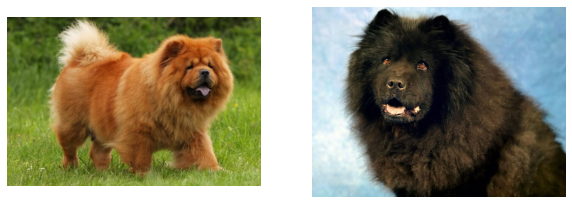

In [101]:
img = 'myimages_test/chowchow.jpg'

dog_prediction = VGG19_JR_predict_breed(img)

fig = plt.figure(figsize=(10, 10))
    
img_show = cv2.imread(img)
cv_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 1)
plt.axis('off')
_ = plt.imshow(cv_rgb)

print("Is it a human face? "+str(face_detector(img)))
print("Does it look like a dog? "+str(dog_detector(img)))
print(" ")
print("If you're truly a dog then you might be a "+dog_prediction.replace('_', ' ').lower())

for file in glob.glob('./dogImages/train/*'+dog_prediction+'*'):
    file = file

img = file+'/'+random.choice(os.listdir(file))
# fig = plt.figure(figsize=(10, 10))
    
img_show = cv2.imread(img)
cv_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 2)
plt.axis('off')
_ = plt.imshow(cv_rgb)

Is it a human face? True
Does it look like a dog? False
 
If you're truly a dog then you might be a cane corso


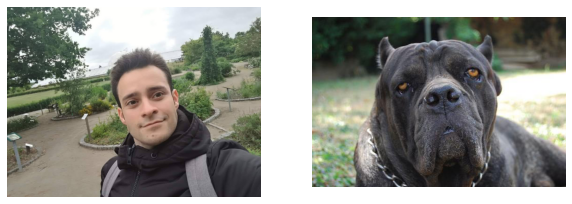

In [103]:
img = 'myimages_test/Junior3.jpg'

dog_prediction = VGG19_JR_predict_breed(img)

fig = plt.figure(figsize=(10, 10))
    
img_show = cv2.imread(img)
cv_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 1)
plt.axis('off')
_ = plt.imshow(cv_rgb)

print("Is it a human face? "+str(face_detector(img)))
print("Does it look like a dog? "+str(dog_detector(img)))
print(" ")
print("If you're truly a dog then you might be a "+dog_prediction.replace('_', ' ').lower())

for file in glob.glob('./dogImages/train/*'+dog_prediction+'*'):
    file = file

img = file+'/'+random.choice(os.listdir(file))
# fig = plt.figure(figsize=(10, 10))
    
img_show = cv2.imread(img)
cv_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
fig.add_subplot(1, 2, 2)
plt.axis('off')
_ = plt.imshow(cv_rgb)